# [9660] Decision Tree 2 - Hyperparameter Tuning
Data file:
* https://raw.githubusercontent.com/vjavaly/Baruch-CIS-9660/main/data/heart_disease_1.csv

In [1]:
from datetime import datetime
print(f'Run time: {datetime.now().strftime("%D %T")}')

Run time: 10/27/24 14:16:45


### Import libraries

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Load data

Dataset by Heart Disease UCI:

Dataset source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Dataset columns:
* age: The person’s age in years
* sex: The person’s sex (1 = male, 0 = female)
* cp: chest pain type
  * Value 0: asymptomatic
  * Value 1: atypical angina
  * Value 2: non-anginal pain
  * Value 3: typical angina
* trestbps: The person’s resting blood pressure (mm Hg on admission to the hospital)
* chol: The person’s cholesterol measurement in mg/dl
* fbs: The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
* restecg: resting electrocardiographic results
  * Value 0: showing probable or definite left ventricular hypertrophy by Estes’ criteria
  * Value 1: normal
  * Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* thalach: The person’s maximum heart rate achieved
* exang: Exercise induced angina (1 = yes; 0 = no)
* oldpeak: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot. See more here)
* slope: the slope of the peak exercise ST segment
  * 0: downsloping
  * 1: flat
  * 2: upsloping
* ca: The number of major vessels (0–3)
* thal: A blood disorder called thalassemia Value 0: NULL (dropped from the dataset previously
  * Value 1: fixed defect (no blood flow in some part of the heart)
  * Value 2: normal blood flow
  * Value 3: reversible defect (a blood flow is observed but it is not normal)
* target: Heart disease (1 = no, 0= yes)

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/vjavaly/Baruch-CIS-9660/main/data/heart_disease_1.csv')

### Examine data

In [4]:
df.shape

(303, 14)

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Separate independent and dependent variables

In [6]:
X = df.drop(columns="target")
y = df["target"]

### Set global variable

In [7]:
global RANDOM_STATE
RANDOM_STATE=42

### Split data into training and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.25, random_state=RANDOM_STATE)

### Train decision tree model

In [9]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [10]:
model.fit(X_train, y_train)
model.get_depth()

9

### Generate accuracy metrics

In [11]:
X_pred = model.predict(X_train)     # Make predictions on training set
y_pred = model.predict(X_test)      # Make predictions on test set
print("Train accuracy:", np.round(accuracy_score(y_train, X_pred), 4))
initial_test_accuracy = np.round(accuracy_score(y_test, y_pred), 4)
print("Initial test accuracy:", initial_test_accuracy)

Train accuracy: 1.0
Initial test accuracy: 0.7237


### Generate confusion matrix (on test set)

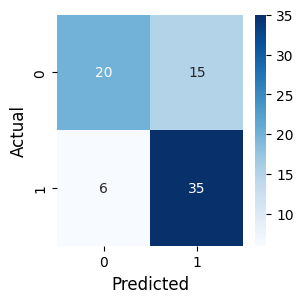

In [12]:
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[3,3])
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

The base model has learned the training data very well, but it does not generalize as well on new input data (test set). In technical terms, our base model is overfitting. Decision tree models have a tendency to overfit.

Let's use Grid Search and Random Search methods to improve our model's performance (test accuracy score)

### Set up hyperparameter grid

In [13]:
# Prepare the hyperparameters values to search
max_depth = [int(x) for x in np.linspace(2, 15, num=6)]
min_samples_leaf = np.arange(2, 15, 3)
min_samples_split = np.arange(2, 7)
max_features = ['log2', 'sqrt']

# Create the hyperparameter grid
grid = {'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features
       }

pprint(grid)

{'max_depth': [2, 4, 7, 9, 12, 15],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': array([ 2,  5,  8, 11, 14]),
 'min_samples_split': array([2, 3, 4, 5, 6])}


In [14]:
# Instantiate the grid search model
#  Note: cv=10
gs = GridSearchCV(model, param_grid=grid,
                  scoring="accuracy", verbose=1,
                  n_jobs=-1, cv=10, return_train_score=True)

### Run grid search

In [15]:
%%time

gs.fit(X_train, y_train)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
CPU times: user 2.31 s, sys: 190 ms, total: 2.5 s
Wall time: 46.4 s


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 7, 9, 12, 15],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': array([ 2,  5,  8, 11, 14]),
                         'min_samples_split': array([2, 3, 4, 5, 6])},
             return_train_score=True, scoring='accuracy', verbose=1)

We tried all 300 hyperparameter combinations times 10 folds for each combination resulting in 3000 trained models

### Review best parameters and accuracy score from grid search

In [16]:
print("Optimal hyperparameter combination:", gs.best_params_)
print("\nMean cross-validated training accuracy score:", np.round(gs.best_score_,4))

Optimal hyperparameter combination: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6}

Mean cross-validated training accuracy score: 0.7636


### Re-train model with best hyperparameters from grid search

In [17]:
# Train with gs.best_params_ from cell above
gs.best_estimator_.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_features='log2', min_samples_leaf=2,
                       min_samples_split=6, random_state=42)

### Review best grid search estimator's predictions

In [18]:
y_pred = gs.best_estimator_.predict(X_test)     # Make predictions on test set
grid_search_test_accuracy = np.round(accuracy_score(y_test, y_pred), 4)
print("Test accuracy:", np.round(accuracy_score(y_test, y_pred), 4))

Test accuracy: 0.7895


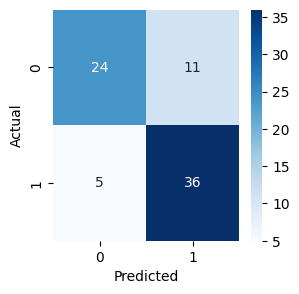

In [19]:
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[3,3])
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Model performance has improved. This time, the model is not overfitting as much. It performs almost as well on both train and test sets (76.36% vs. 78.95%). In addition to that, both false positives and false negatives have slightly reduced after tuning hyperparameters.

### Set up random search

In [20]:
# Use the same hyperparameter grid
#  Notes: cv=10 (same as for grid search), and n_iter=50
rs = RandomizedSearchCV(model, param_distributions=grid,
                        n_iter=50, scoring="accuracy", random_state=RANDOM_STATE,
                        n_jobs=-1, cv=10, return_train_score=True)

### Run random search

In [21]:
%%time

rs.fit(X_train, y_train)

CPU times: user 355 ms, sys: 19.2 ms, total: 374 ms
Wall time: 3.26 s


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 7, 9, 12, 15],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': array([ 2,  5,  8, 11, 14]),
                                        'min_samples_split': array([2, 3, 4, 5, 6])},
                   random_state=42, return_train_score=True,
                   scoring='accuracy')

We tried a randomly selected set of 50 hyperparameter combinations times 10 folds for each combination resulting in 500 trained models

### Review best parameters and accuracy score from random search

In [22]:
print("Optimal hyperparameter combination:", rs.best_params_)
print("\tNote: Different combination of hyperparameter values than from grid search")
print("\nMean cross-validated training accuracy score:", np.round(rs.best_score_,4))

Optimal hyperparameter combination: {'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 7}
	Note: Different combination of hyperparameter values than from grid search

Mean cross-validated training accuracy score: 0.7636


### Re-train model with best hyperparameters from random search

In [23]:
# Train with rs.best_params_ from cell above
rs.best_estimator_.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, max_features='log2', min_samples_leaf=2,
                       min_samples_split=6, random_state=42)

### Review best random search estimator's predictions

In [24]:
y_pred = rs.best_estimator_.predict(X_test)     # Make predictions on test set
random_search_test_accuracy = np.round(accuracy_score(y_test, y_pred), 4)
print("Test accuracy:", np.round(accuracy_score(y_test, y_pred), 4))

Test accuracy: 0.7895


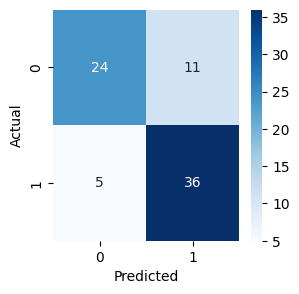

In [25]:
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[3,3])
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Performance summary

In [26]:
print("Test accuracy")
print("=============")
print("Initial model =", initial_test_accuracy)
print("After grid search =", grid_search_test_accuracy)
print("After random search =", random_search_test_accuracy)

Test accuracy
Initial model = 0.7237
After grid search = 0.7895
After random search = 0.7895


The model performance after random search is the same (78.95%) as after Grid Search.  
However, random search's execution time is significantly less than grid search's.